In [17]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import mplniw.sigp as sp
import mplniw.utils as ut
import niskine

In [18]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'
figdir = '/Users/zcasparcohen/Documents/NISKINE/Figures/'

In [19]:
#Definition filter
Tw = 30  # Kernel length
#omega = 2.0 
omega = ut.coriolis(lat)*3600*24/(2*np.pi)  # Central frequency
#bandwidth = None 
bandwidth = 0.1
dt = 1/(24*6)  # Time step in days unit
h = ut.generate_filter(omega,dt=dt,T=Tw,bandwidth=bandwidth,lat=lat,pass_zero=False)  # Best filter
h_hat, w = ut.filter_response(h, dt=dt)  #Filter response

In [85]:
moorings={}
for mooring in [1,2,3]:
    #gridded=xr.open_dataset(root_dir+'M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
    gridded = xr.open_dataset(root_dir+'M%s_lpfiltered.nc'%mooring)#.interpolate_na(dim='time',method='cubic',max_gap=pd.Timedelta(3, "d"))
    ds = gridded[['u','v','u_filtered','v_filtered']]#.expand_dims({'lat':[lat],'lon':[lon]}) #sp.wrap_filter(gridded,h,**{'hilbert':False})
    mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds.time[0],ds.time[-1]))
    ds['mld'] = mld_m1
    #print(ds)
    #wkb = niskine.clim.get_wkb_factors(gridded)
    #ds['bpu_wkb'] = ds['u_filtered']*wkb
    #ds['bpv_wkb'] = ds['v_filtered']*wkb
#ds.bp_eke.attrs.update({'long_name':'Kinetic energy', 'units':r'$m^2.s^{-2}$'})
    #ds.bpu_wkb.attrs.update({'long_name':'Zonal velocity', 'units':r'$m.s^{-1}$'})
    #ds.bpv_wkb.attrs.update({'long_name':'Meridional velocity', 'units':r'$m.s^{-1}$'})
#ds['bp_eke'] = ds.bp_eke.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
    #ds['bpu_wkb'] = ds.bpu_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
    #ds['bpv_wkb'] = ds.bpv_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
    #ds['u_filtered'] = ds.u_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
    #ds['v_filtered'] = ds.v_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
    moorings[str(mooring)] = ds

In [86]:
for mooring in moorings:
    moorings[mooring] = moorings[mooring].where(np.isnan(moorings['3'].u)==False)

In [87]:
for mooring in moorings:
    moorings[mooring] = moorings[mooring].where((np.isnan(moorings['2'].u)==False)&(moorings['2'].count('time')>1000))

In [66]:
for m in moorings:
    lon, lat, bottom_depth = niskine.io.mooring_location(mooring=int(m))
    moorings[m] = moorings[m].expand_dims({'lat':[lat],'lon':[lon]})

In [90]:
R = 15*1e3/np.sqrt(3)
RV = 2/3/R*((moorings['2'].v_filtered+moorings['1'].v_filtered)/2-moorings['3'].v_filtered)-1/np.sqrt(3)/R*(moorings['1'].u_filtered-moorings['2'].u_filtered)

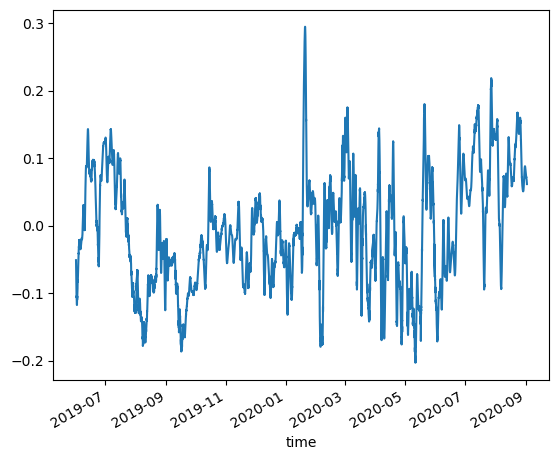

In [97]:
(RV/fc).mean('z').sel(time=slice('2019-06-01','2020-09-01')).plot()

In [69]:
ds_combined = xr.combine_nested([[moorings['1'],moorings['2'],moorings['3']]],concat_dim=['lon','lat'])

In [72]:
ds_combined

<xarray.Dataset>
Dimensions:     (lon: 3, time: 73057, z: 125, lat: 3)
Coordinates:
  * lon         (lon) float64 -21.42 -21.2 -21.2
  * time        (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-06
  * z           (z) int64 0 16 32 48 64 80 96 ... 1904 1920 1936 1952 1968 1984
  * lat         (lat) float64 59.1 58.97 59.03
Data variables:
    u           (lat, lon, z, time) float64 nan nan nan nan ... nan nan nan nan
    v           (lat, lon, z, time) float64 nan nan nan nan ... nan nan nan nan
    u_filtered  (lat, lon, z, time) float64 nan nan nan nan ... nan nan nan nan
    v_filtered  (lat, lon, z, time) float64 nan nan nan nan ... nan nan nan nan
    mld         (lat, lon, time, z) float64 nan nan nan nan ... nan nan nan nan

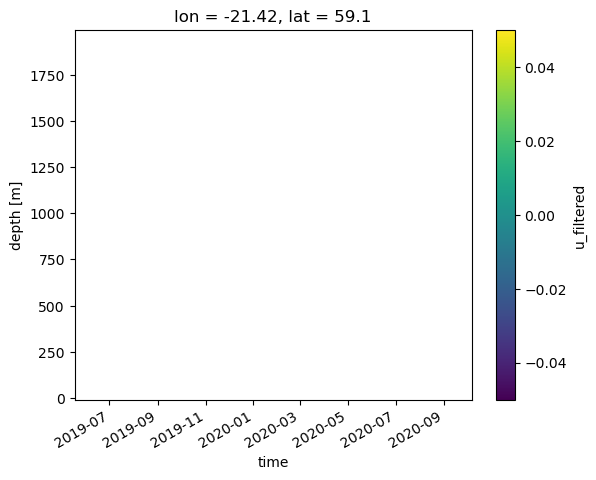

In [70]:
ds_combined.u_filtered.isel(lon=0,lat=0).plot()

In [9]:
import mplniw.plot as pl

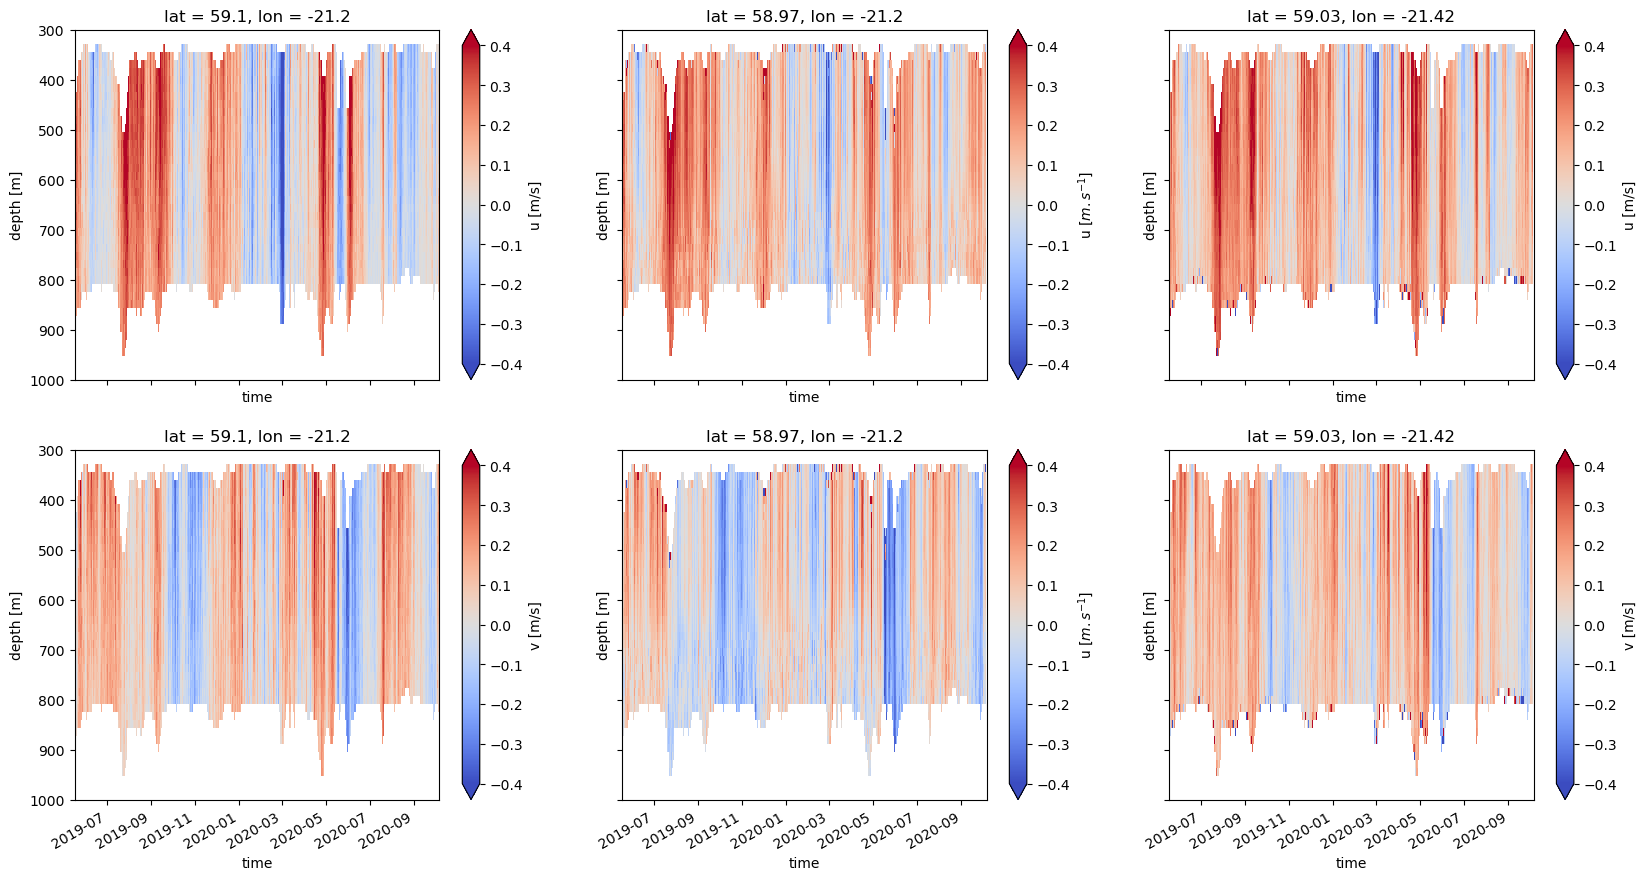

In [54]:
fig,axes = plt.subplots(2,3,figsize=(20,10),sharey=True,sharex=True)
for i, m in enumerate([1,2,3]):
    ax=axes[0,i]
    pl.plot_uv(moorings[str(m)],'u',fig,ax)
    ax.set_ylim(1000,300)
    ax=axes[1,i]
    pl.plot_uv(moorings[str(m)],'v',fig,ax)
    ax.set_ylim(1000,300)

-21.198829621395166 59.101445324829214
-21.196656975200398 58.96598147489824
-21.417375289217556 59.030217712396855


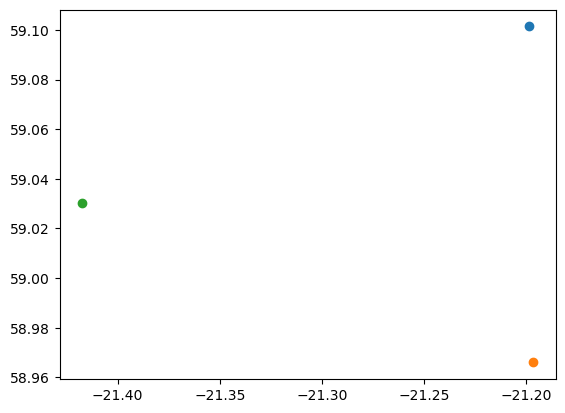

In [11]:
Lon,Lat = [],[]
for m in [1,2,3]:
    lon,lat,depth = niskine.io.mooring_location(mooring=m)
    plt.scatter(lon,lat)
    print(lon,lat)
    Lon.append(lon)
    Lat.append(lat)

In [73]:
R_earth =  6371
fc = ut.coriolis(np.sum(Lat)/3)

In [74]:
m=1
dx = R_earth*1e3*np.abs(Lon[m]-Lon[m+1])*np.pi/180
dy = R_earth*1e3*np.abs(Lat[m]-Lat[m+1])*np.pi/180
dudy = (moorings[str(m+1)].u_filtered-moorings[str(m+2)].u_filtered)/dy
dvdx = (moorings[str(m+1)].u_filtered-moorings[str(m+1)].v_filtered)/dx
#((dvdx-dudy).mean('z')/fc).plot()

In [75]:
_dx = R_earth*1e3*np.abs(Lon[0]-Lon[2])*np.pi/180
_dy = R_earth*1e3*np.abs(Lat[0]-Lat[2])*np.pi/180
_dudy = (moorings['1'].u_filtered-moorings['3'].u_filtered)/dy
_dvdx = (moorings['1'].u_filtered-moorings['3'].v_filtered)/dx

In [76]:
dudy

<xarray.DataArray 'u_filtered' (lat: 0, lon: 0, z: 125, time: 73057)>
array([], shape=(0, 0, 125, 73057), dtype=float64)
Coordinates:
  * time     (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-06
  * z        (z) int64 0 16 32 48 64 80 96 ... 1904 1920 1936 1952 1968 1984
  * lat      (lat) float64 
  * lon      (lon) float64

In [77]:
((dvdx-dudy).mean('z')/fc).plot()
((_dvdx-_dudy).mean('z')/fc).plot()

TypeError: No numeric data to plot.

In [57]:
import xgcm

In [58]:
test = xgcm.autogenerate.generate_grid_ds(gridded,{'Z':'z'})

In [64]:
gridx = xgcm.Grid(ds_combined,{'X':{'center':'lon'},'Y':{'center':'lat'},'Z':{'center':'z'}}, periodic=['X', 'Y'])

In [66]:
zeta_filter = (gridx.diff(ds_combined['v_filtered'],'X') - gridx.diff(ds_combined['u_filtered'],'lat'))
zeta_filter_ij = gridx.interp(gridx.interp(zeta_filter, 'Y'), 'X')
#zeta_filter_f = (zeta_filter_ij/f_ij)

KeyError: 'lon'

In [74]:

#gridx.diff?
ds_combined['v_filtered']


<xarray.DataArray 'v_filtered' (lat: 3, lon: 3, z: 125, time: 73057)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lon      (lon) float64 -21.42 -21.2 -21.2
  * time     (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-06
  * z        (z) int64 0 16 32 48 64 80 96 ... 1904 1920 1936 1952 1968 1984
  * lat      (lat) float64 59.1 58.97 59.03

In [71]:

gridx.diff(ds_combined['v_filtered'],['X'])

KeyError: 'X'

In [78]:
R = 15*1e3/np.sqrt(3)

In [79]:
RV = 2/3/R*((moorings['2'].v_filtered+moorings['1'].v_filtered)/2-moorings['3'].v_filtered)-1/np.sqrt(3)/R*(moorings['1'].u_filtered-moorings['2'].u_filtered)
RV_mean = RV.rolling(time=int(5/dt)).mean()

In [81]:
moorings['2'].v_filtered

<xarray.DataArray 'v_filtered' (lat: 1, lon: 1, z: 125, time: 73057)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float64 58.97
  * lon      (lon) float64 -21.2
  * time     (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-06
  * z        (z) int64 0 16 32 48 64 80 96 ... 1904 1920 1936 1952 1968 1984

In [80]:
(RV/fc).plot(yincrease=False,ylim=(1000,300),cmap='coolwarm')

plt.figure()
(RV_mean/fc).plot(yincrease=False,ylim=(1000,300),cmap='coolwarm')

TypeError: No numeric data to plot.

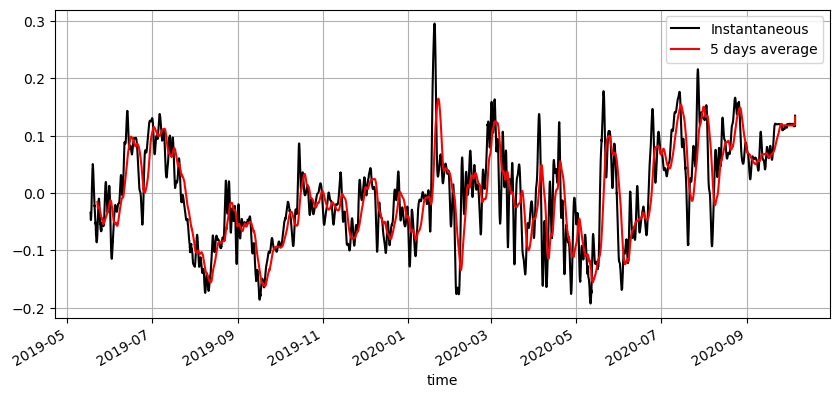

In [124]:
fig,ax = plt.subplots(figsize=(10,4))
(RV.mean('z')/fc).plot(ax=ax,label='Instantaneous',c='k')
(RV_mean.mean('z')/fc).plot(ax=ax,label='5 days average',c='r')
ax.grid();ax.legend()

In [126]:
t_start = xr.open_dataarray(root_dir+'tstart.nc')
t_end = xr.open_dataarray(root_dir+'tend.nc')

In [130]:
t_start[0].values

numpy.datetime64('2019-09-15T23:00:00.000000000')

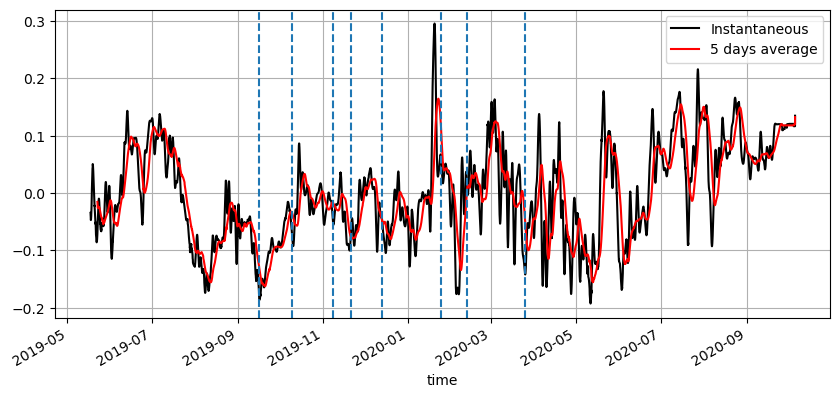

In [146]:
fig,ax = plt.subplots(figsize=(10,4))
(RV.mean('z')/fc).plot(ax=ax,label='Instantaneous',c='k')
(RV_mean.mean('z')/fc).plot(ax=ax,label='5 days average',c='r')
ax.grid();ax.legend()
#ax.fill_between("y",t_start[0].values,t_end[0].values)
for ti,tf in zip(t_start,t_end):
    ax.axvline(ti.values,ls='--')
    ax.axvline(tf.values,ls='--')